# Source
https://studentlife.cs.dartmouth.edu/dataset.html

# Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

# Helper Functions

In [2]:
from os import listdir
from os.path import isfile,join

def create_dict_from_folder(folder_path,file_type='json'):
    """Method to load all files from the input folder and convert them to df's. 
    A dictionary of (uid,df) pairs is returned. """
    
    #create all file paths within folder
    file_paths = [folder_path+f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    
    #find start/end position of uid in file_path
    uid_start_pos = file_paths[0].find('_u') + 1
    uid_end_pos = uid_start_pos + 3

    df_dict = {}
    for path in file_paths:
        uid = path[uid_start_pos:uid_end_pos] #extract uid from path
        if file_type == 'json':
            df_dict[uid] = pd.read_json(path)
        elif file_type == 'csv':
            df_dict[uid] = pd.read_csv(path)
         
    return df_dict

In [3]:
def find_null_cols(df):
    """Method to create a list of all null cols of a df"""
    
    temp_df = np.sum(df.isnull())
    
    return [col for col in temp_df.index if temp_df[col]!=0]

In [4]:
def fill_nulls(df,method='most_freq'):
    """Method to fill null values of a df.
    Input:
        - df
        - method: {'most_freq','mean'} 
    """
    
    for col in find_null_cols(df):
        if method=='most_freq':
            most_freq = df[col].value_counts().index[0]
            df[col] = df[col].fillna(value=most_freq)
        elif method=='mean':
            df[col] = df[col].fillna(value=df[col].mean())
            
    return df
    

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale_df(df,scaler='MinMax'):
    """Method to shift the data such that all cols are exactly between 0 and 1."""
    
    # instantiate and fit selected scaler
    if scaler == 'MinMax':
        scaler = MinMaxScaler().fit(df.values)
    elif scaler == 'Standard':
        scaler = StandardScaler().fit(df.values)
    
    # scale df
    df_scaled = pd.DataFrame(data=scaler.transform(df.values),
                                 index=df.index,
                                 columns=df.columns)
    
    return df_scaled
    


In [6]:
def compute_net_score(df,col_name):
    name = df
    df = scale_df(df)
    scores_df = pd.DataFrame(data = [0]*len(df), index=df.index, columns=[col_name])
    for col in df.columns:
        if col[-1] == '+':
            scores_df = scores_df.add(df[col],axis=0)
        elif col[-1] == '-':
            scores_df = scores_df.sub(df[col],axis=0)
            
    return scores_df

# Data Exploration

We wish to study the dependency of students's school performance with:

A. Phone Activity <br>
B. Ecological Momentary Assessment (EMA) in Physical Activity<br>
C. Mental Health

# A. Phone Activity
Use the data from this folder to measure phone activity

In [7]:
sensing_path = './dataset/dataset/sensing/'
[f for f in listdir(sensing_path)]

['activity',
 'audio',
 'bluetooth',
 'conversation',
 'dark',
 'gps',
 'phonecharge',
 'phonelock',
 'wifi',
 'wifi_location']

Let us study the following folders:

1. 'conversation'
2. 'phonelock'

## A.1. Conversation

In [8]:
def conversation_scores_df():
    """Method to compute total conversation time (in sec) per user. 
    Output: a df with 
        - index = uid
        - columns = [tot_conv_sec]
    """
    # load data and create dict of df's
    folder_path = sensing_path+'conversation/'
    df_dict = create_dict_from_folder(folder_path,file_type='csv')
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    for uid,df in df_dict.items():
        
        try:
            #convert cols to timestamps
            for col in df.columns:
                df[col] = pd.to_datetime(df[col], unit='s')
            tot_conv_sec = ((df.iloc[:,1]-df.iloc[:,0]).dt.seconds).sum()
            score_dict[uid] = tot_conv_sec
        except:
            pass
        
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index',
                                columns=['tot_conv_sec'])
    df.index.name = 'uid'
    
    return df

In [9]:
conversation_df = conversation_scores_df()
conversation_df.head()

,tot_conv_sec
uid,
u00,1604596
u01,1664813
u02,1260149
u03,248496
u04,1505986


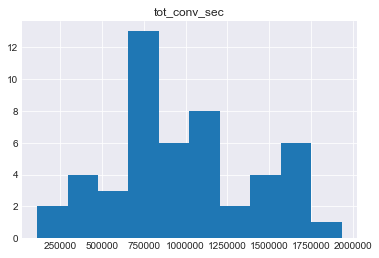

In [10]:
_ =  conversation_df.hist()

## A.2. Phonelock

In [11]:
def phonelock_scores_df():
    """Method to compute total phonelock time (in sec) per user. 
    Output: a df with 
        - index = uid
        - columns = [tot_phonelock_sec]
    """
    # load data and create dict of df's
    folder_path = sensing_path+'phonelock/'
    df_dict = create_dict_from_folder(folder_path,file_type='csv')
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    for uid,df in df_dict.items():
        
        try:
            #convert cols to timestamps
            for col in df.columns:
                df[col] = pd.to_datetime(df[col], unit='s')
            tot_phonelock_sec = ((df.iloc[:,1]-df.iloc[:,0]).dt.seconds).sum()
            score_dict[uid] = tot_phonelock_sec
        except:
            pass
        
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index',
                                columns=['tot_phonelock_sec'])
    df.index.name = 'uid'
    
    return df

In [12]:
phonelock_scores_df = phonelock_scores_df()
phonelock_scores_df.head()

,tot_phonelock_sec
uid,
u00,2137464
u01,3084557
u02,1613057
u03,1514704
u04,3493669


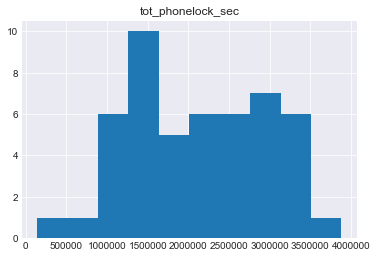

In [13]:
_ = phonelock_scores_df.hist()

In [14]:
phone_scores_df = pd.merge(conversation_df, phonelock_scores_df, how='outer', on='uid')
phone_scores_df['pct_phone_usage'] = phone_scores_df.tot_conv_sec/phone_scores_df.tot_phonelock_sec
phone_scores_df.head()

,tot_conv_sec,tot_phonelock_sec,pct_phone_usage
uid,,,
u00,1604596,2137464,0.750701
u01,1664813,3084557,0.539725
u02,1260149,1613057,0.781218
u03,248496,1514704,0.164056
u04,1505986,3493669,0.431061


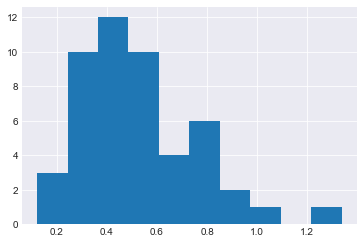

In [15]:
_ = phone_scores_df.pct_phone_usage.hist()

# B. EMA
Use the data from this folder to assess physical health

In [16]:
ema_info = pd.read_json('./dataset/dataset/EMA/EMA_definition.json').set_index(['name'])
ema_info.index.tolist();

Let us study the following files:

1. 'Sleep'
2. 'Stress'
3. 'Social'
4. 'Activity'
5. 'Exercise'
6. 'Mood'
7. 'Behavior'


For each file we will compute a df of scores which we can then use to assess the physical health of each student. 

## B.1. Sleep

In [17]:
ema_info.loc['Sleep',:][0]

[{'options': '[1]<3, [2]3.5, [3]4, [4]4.5, [5]5, [6]5.5, [7]6, [8]6.5, [9]7, [10]7.5, [11]8, [12]8.5, [13]9, [14]9.5, [15]10, [16]10.5, [17]11, [18]11.5, [19]12, ',
  'question_id': 'hour',
  'question_text': 'How many hours did you sleep last night? '},
 {'options': '[1]Very good, [2]Fairly good, [3]Fairly bad, [4]Very bad, ',
  'question_id': 'rate',
  'question_text': 'How would rate your overall sleep last night?'},
 {'options': '[1]None, [2]Once, [3]Twice, [4]Three or more times, ',
  'question_id': 'social',
  'question_text': 'How often did you have trouble staying awake yesterday while in class, eating meals or engaging in social activity?'},
 {'options': '', 'question_id': 'location', 'question_text': ''}]

In [18]:
def sleep_score_df():
    """Method to assess sleep quantity/quality. 
    Output: a df with 
        - index = uid
        - columns = [sleep_hour_+ (higher = more),
                     sleep_rate_- (lower = better),
                     sleep_social_- (lower = better)]
    """
    # load data and create dict of df's
    df_dict = create_dict_from_folder('./dataset/dataset/EMA/response/Sleep/')
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    for uid,df in df_dict.items():
        
        try:
            sleep_hour, sleep_rate, sleep_social = df.hour.mean(), df.rate.mean(), df.social.mean()
            score_dict[uid] = (sleep_hour, sleep_rate, sleep_social)
        except:
            pass
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index', 
                                columns=['sleep_hour_+','sleep_rate_-', 'sleep_social_-'])
    df.index.name = 'uid'
    
    return df

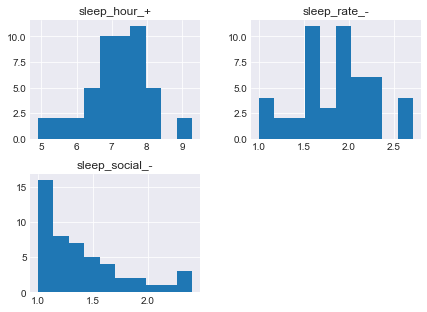

In [19]:
sleep_df = sleep_score_df()
_ = sleep_df.hist(figsize=(7,5))

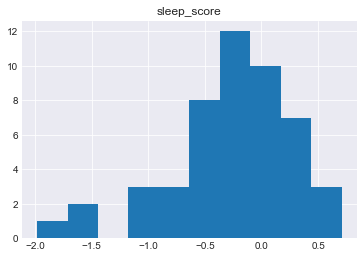

In [20]:
sleep_scores_df = compute_net_score(sleep_df,'sleep_score')
_ = sleep_scores_df.hist()

## B.2. Stress

In [21]:
ema_info.loc['Stress',:][0]

[{'options': '[1]A little stressed, [2]Definitely stressed, [3]Stressed out, [4]Feeling good, [5]Feeling great, ',
  'question_id': 'level',
  'question_text': 'Right now, I am...'},
 {'options': '', 'question_id': 'location', 'question_text': ''}]

In [22]:
def stress_score_df():
    """Method to assess stress. 
    Output: a df with 
        - index = uid
        - columns = stress_level_+ (higher = better)
    """
    # load data and create dict of df's
    df_dict = create_dict_from_folder('./dataset/dataset/EMA/response/Stress/')
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    for uid,df in df_dict.items():
        
        try:
            # swap level 1 with 3 such that stress levels are ordered from 1(high) to 5(low)
            df.level = df.level.map({1:3,3:1})

            score_dict[uid] = df.level.mean()
        except:
            pass
    
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index', 
                                columns=['stress_level_+'])
    df.index.name = 'uid'
    

    return df.dropna()

In [23]:
stress_df = stress_score_df()

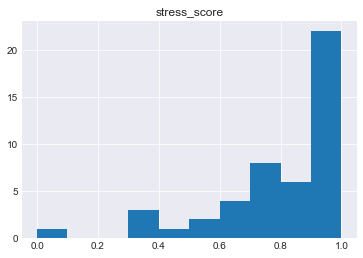

In [24]:
stress_scores_df = compute_net_score(stress_df,'stress_score')
_ = stress_scores_df.hist()

## B.3. Social

In [25]:
ema_info.loc['Social',:][0]

[{'options': '[1]0-4 persons, [2]5-9 persons, [3]10-19 persons, [4]20-49 persons, [5]50-99 persons, [6]over 100 persons, ',
  'question_id': 'number',
  'question_text': 'How many people did you have contact with yesterday, including anyone you said hello to, chatted, talked or discussed matters with, whether you did it face-to-face, by telephone, by mail or on the internet, and whether you personally knew the person or not? Please select one of the following categories that best matches your estimate:'},
 {'options': '', 'question_id': 'location', 'question_text': ''}]

In [26]:
def social_score_df():
    """Method to assess social activity. 
    Output: a df with 
        - index = uid
        - columns = social_number_+ (higher = more)
    """
    # load data and create dict of df's
    df_dict = create_dict_from_folder('./dataset/dataset/EMA/response/Social/')
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    for uid,df in df_dict.items():
        
        try:
            score_dict[uid] = df.number.mean()
        except:
            pass
    
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index', 
                                columns=['social_number_+'])
    df.index.name = 'uid'
    

    return df

In [27]:
social_df = social_score_df()

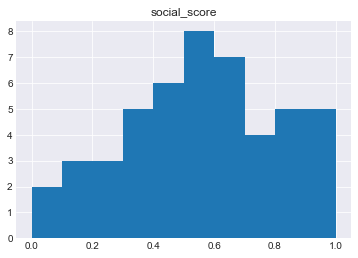

In [28]:
social_scores_df = compute_net_score(social_df,'social_score')
_ = social_scores_df.hist()

## B.4. Activity

In [29]:
ema_info.loc['Activity',:][0]

[{'options': '[1]0-10%, [2]11-25%, [3]26-50%, [4]51-75%, [5]76-100%, ',
  'question_id': 'working',
  'question_text': 'alone working'},
 {'options': '[1]0-10%, [2]11-25%, [3]26-50%, [4]51-75%, [5]76-100%, ',
  'question_id': 'relaxing',
  'question_text': 'alone relaxing'},
 {'options': '[1]0-10%, [2]11-25%, [3]26-50%, [4]51-75%, [5]76-100%, ',
  'question_id': 'other_working',
  'question_text': 'with other people working'},
 {'options': '[1]0-10%, [2]11-25%, [3]26-50%, [4]51-75%, [5]76-100%, ',
  'question_id': 'other_relaxing',
  'question_text': 'with other people relaxing'},
 {'options': '', 'question_id': 'location', 'question_text': 'location'}]

In [30]:
def activity_score_df():
    """Method to assess activity. 
    Output: a df with 
        - index = uid
        - columns = [activity_alone_working_+ ,
                     activity_relaxing_+ ,
                     activity_with_other_working_+,
                     activity_with_other_relaxing_+,
                     ] (higher = more)

    """
    # load data and create dict of df's
    df_dict = create_dict_from_folder('./dataset/dataset/EMA/response/Activity/')
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    for uid,df in df_dict.items():
        
        try:
            score_dict[uid] = (df.working.mean(), 
                               df.relaxing.mean(), 
                               df.other_working.mean(),
                               df.other_relaxing.mean())
        except:
            pass
    
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index', 
                                columns=['activity_alone_working_+', 
                                         'activity_relaxing_+' ,
                                         'activity_with_other_working_+',
                                         'activity_with_other_relaxing_+'])                         
    df.index.name = 'uid'
     

    return df

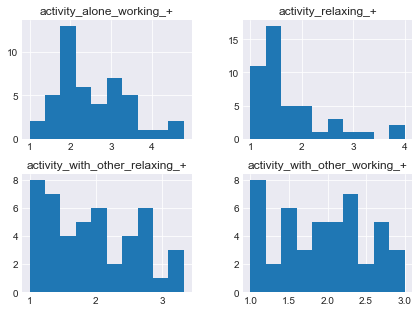

In [31]:
activity_df = activity_score_df()
_ = activity_df.hist(figsize=(7,5))

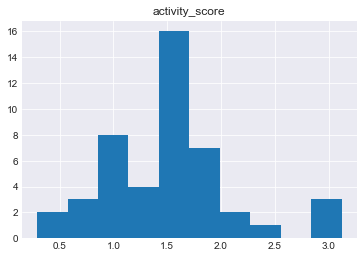

In [32]:
activity_scores_df = compute_net_score(activity_df,'activity_score')
_ = activity_scores_df.hist()

## B.5. Exercise

In [33]:
ema_info.loc['Exercise',:][0]

[{'options': '(Yes) 1 2 (No)',
  'question_id': 'have',
  'question_text': "Did you do vigorous exercise today (don't include walking) such as run, swim, cycle, play a sport"},
 {'options': '(Yes) 1 2 (No)',
  'question_id': 'schedule',
  'question_text': "If no did you want to but couldn't because of your schedule?"},
 {'options': '[1]None, [2]<30 mins, [3]30-60 mins, [4]60-90 mins, [5]>90mins, ',
  'question_id': 'exercise',
  'question_text': 'If you exercised how long did you exercise for?'},
 {'options': '', 'question_id': 'location', 'question_text': ''},
 {'options': '[1]None, [2]<30 mins, [3]30-60 mins, [4]60-90 mins, [5]>90mins, ',
  'question_id': 'walk',
  'question_text': 'How long did you walk for today?'}]

In [34]:
def exercise_score_df():
    """Method to assess exercise. 
    Output: a df with 
        - index = uid
        - columns = [exercise_vigorous_+ (higher = more),
                     exercise_walk_+ (higher=more)
                     ]

    """
    # load data and create dict of df's
    df_dict = create_dict_from_folder('./dataset/dataset/EMA/response/Exercise/')
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    for uid,df in df_dict.items():
        
        try:
            score_dict[uid] = (df.exercise.mean(), df.walk.mean())
                               
        except:
            pass
    
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index', 
                                columns=['exercise_vigorous_+', 
                                         'exercise_walk_+'])
    df.index.name = 'uid'

    return df

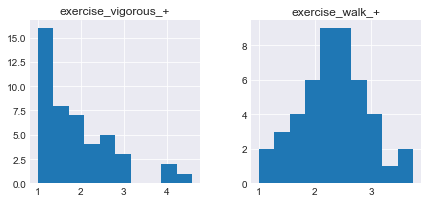

In [35]:
exercise_df = exercise_score_df()
_ = exercise_df.hist(figsize=(7,3))

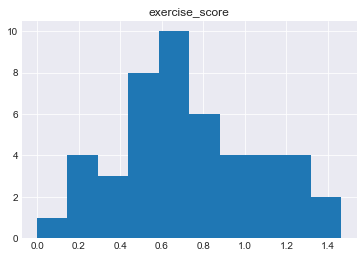

In [36]:
exercise_scores_df = compute_net_score(exercise_df,'exercise_score')
_ = exercise_scores_df.hist()

## B.6. Mood

In [37]:
ema_info.loc['Mood',:][0]

[{'options': '(Yes) 1 2 (No)',
  'question_id': 'happyornot',
  'question_text': 'Do you feel AT ALL happy right now?'},
 {'options': '[1]a little bit, [2]somewhat, [3]very much, [4]extremely, ',
  'question_id': 'happy',
  'question_text': 'If you answered "Yes" on the first question, how happy do you feel? '},
 {'options': '(Yes) 1 2 (No)',
  'question_id': 'sadornot',
  'question_text': 'Do you feel AT ALL sad right now? '},
 {'options': '[1]a little bit, [2]somewhat, [3]very much, [4]extremely, ',
  'question_id': 'sad',
  'question_text': 'If you answered "Yes" on the third question, how sad do you feel?'},
 {'options': '', 'question_id': 'location', 'question_text': ''}]

In [38]:
def mood_score_df():
    """Method to assess mood. 
    Output: a df with 
        - index = uid
        - columns = [mood_happy_+ (higher = more),
                     mood_sad_- (higher=more)
                     ]

    """
    # load data and create dict of df's
    df_dict = create_dict_from_folder('./dataset/dataset/EMA/response/Mood/')
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    for uid,df in df_dict.items():
        
        try:
            score_dict[uid] = (df.happy.mean(), df.sad.mean())
                               
        except:
            pass
    
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index', 
                                columns=['mood_happy_+', 
                                         'mood_sad_-'])
    df.index.name = 'uid'
     
    return df

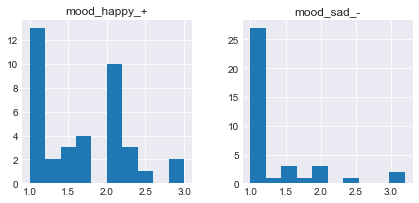

In [39]:
mood_df = mood_score_df()
_ = mood_df.hist(figsize=(7,3))

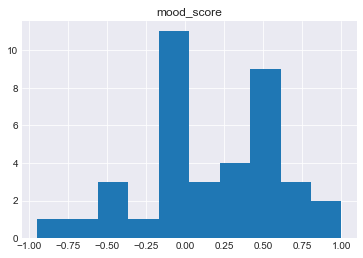

In [40]:
mood_scores_df = compute_net_score(mood_df,'mood_score')
_ = mood_scores_df.hist()

## B.7. Behavior

In [41]:
ema_info.loc['Behavior',:][0]

[{'options': '(Not at all) 1 2 3 4 5 (Extremely)',
  'question_id': 'enthusiastic',
  'question_text': 'In the past 15 minutes, I was extraverted, enthusiastic.                (Scale: 1=Not at all; 2=A little; 3=somewhat; 4=very; 5=extremely)'},
 {'options': '(Not at all) 1 2 3 4 5 (Extremely)',
  'question_id': 'critical',
  'question_text': '......, I was critical, quarrelsome.'},
 {'options': '(Not at all) 1 2 3 4 5 (Extremely)',
  'question_id': 'dependable',
  'question_text': '......, I was dependable, self-disciplined.'},
 {'options': '(Not at all) 1 2 3 4 5 (Extremely)',
  'question_id': 'anxious',
  'question_text': '......, I was anxious, easily upset.'},
 {'options': '(Not at all) 1 2 3 4 5 (Extremely)',
  'question_id': 'experiences',
  'question_text': '......, I was open to new experiences, complex.'},
 {'options': '(Not at all) 1 2 3 4 5 (Extremely)',
  'question_id': 'reserved',
  'question_text': '......, I was reserved, quiet.'},
 {'options': '(Not at all) 1 2 3 4 5 (

In [42]:
def behavior_score_df():
    """Method to assess behavior. 
    Output: a df with 
        - index = uid
        - columns = ['behavior_anxious_-',
                     'behavior_calm_+',
                     'behavior_conventional_-',
                     'behavior_critical_-',
                     'behavior_dependable_+',
                     'behavior_disorganized_-',
                     'behavior_enthusiastic_+',
                     'behavior_experiences_+',
                     'behavior_reserved_-',
                     'behavior_sympathetic_+']
                     (higher = more)

    """
    # load data and create dict of df's
    df_dict = create_dict_from_folder('./dataset/dataset/EMA/response/Behavior/')
    
    # define cols of interest
    cols =  ['anxious',
             'calm',
             'conventional',
             'critical',
             'dependable',
             'disorganized',
             'enthusiastic',
             'experiences',
             'reserved',
             'sympathetic']
    
    
    # compute important stats and build a dict of (uid,stats)
    score_dict = {}
    
    for uid,df in df_dict.items():
        
            try:
                temp_score_list = []
                for col in cols:
                    temp_score_list.append(df.loc[:,col].mean())
                score_dict[uid] = tuple(temp_score_list)

            except:
                pass
    
    
    # create df from score_dict
    df = pd.DataFrame.from_dict(score_dict, 
                                orient='index', 
                                columns=['behavior_anxious_-',
                                         'behavior_calm_+',
                                         'behavior_conventional_-',
                                         'behavior_critical_-',
                                         'behavior_dependable_+',
                                         'behavior_disorganized_-',
                                         'behavior_enthusiastic_+',
                                         'behavior_experiences_+',
                                         'behavior_reserved_-',
                                         'behavior_sympathetic_+'])
    df.index.name = 'uid'
    

    return df

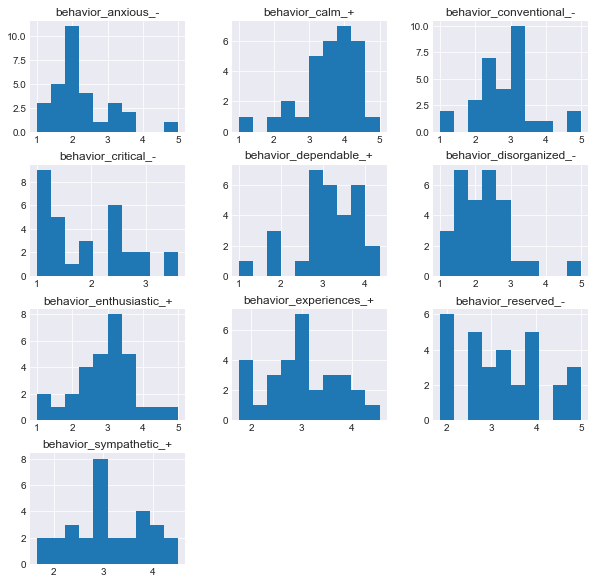

In [43]:
behavior_df = behavior_score_df()
_ = behavior_df.hist(figsize=(10,10))

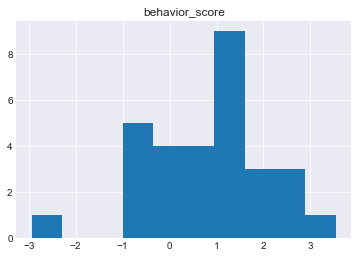

In [44]:
behavior_scores_df = compute_net_score(behavior_df,'behavior_score')
_ = behavior_scores_df.hist()

## Join all EMA df's

In [45]:
ema_scores_df_list = [sleep_scores_df, stress_scores_df, social_scores_df, 
                       activity_scores_df, exercise_scores_df, mood_scores_df, 
                       behavior_scores_df]

In [46]:
# Join all EMA df on index = uid
ema_scores_df = sleep_scores_df
for df in ema_scores_df_list[1:]:
    ema_scores_df = pd.merge(ema_scores_df,df,how='outer',on='uid')

# fill null cols with mean value of col
ema_scores_df = fill_nulls(ema_scores_df,method='mean')

ema_scores_df.head()

,sleep_score,stress_score,social_score,activity_score,exercise_score,mood_score,behavior_score
uid,,,,,,,
u00,-0.148492,0.724456,0.567449,1.515873,0.533306,0.022727,0.860762
u01,-0.425579,0.935811,0.725806,2.120370,0.519481,0.500000,0.763769
u02,-0.170330,1.000000,0.522581,1.445933,0.792929,0.000000,2.396797
u03,0.228807,0.828829,0.159677,1.068001,0.652146,0.000000,0.860762
u04,-0.261197,0.607313,0.602151,1.908425,1.432239,0.034091,-0.720497


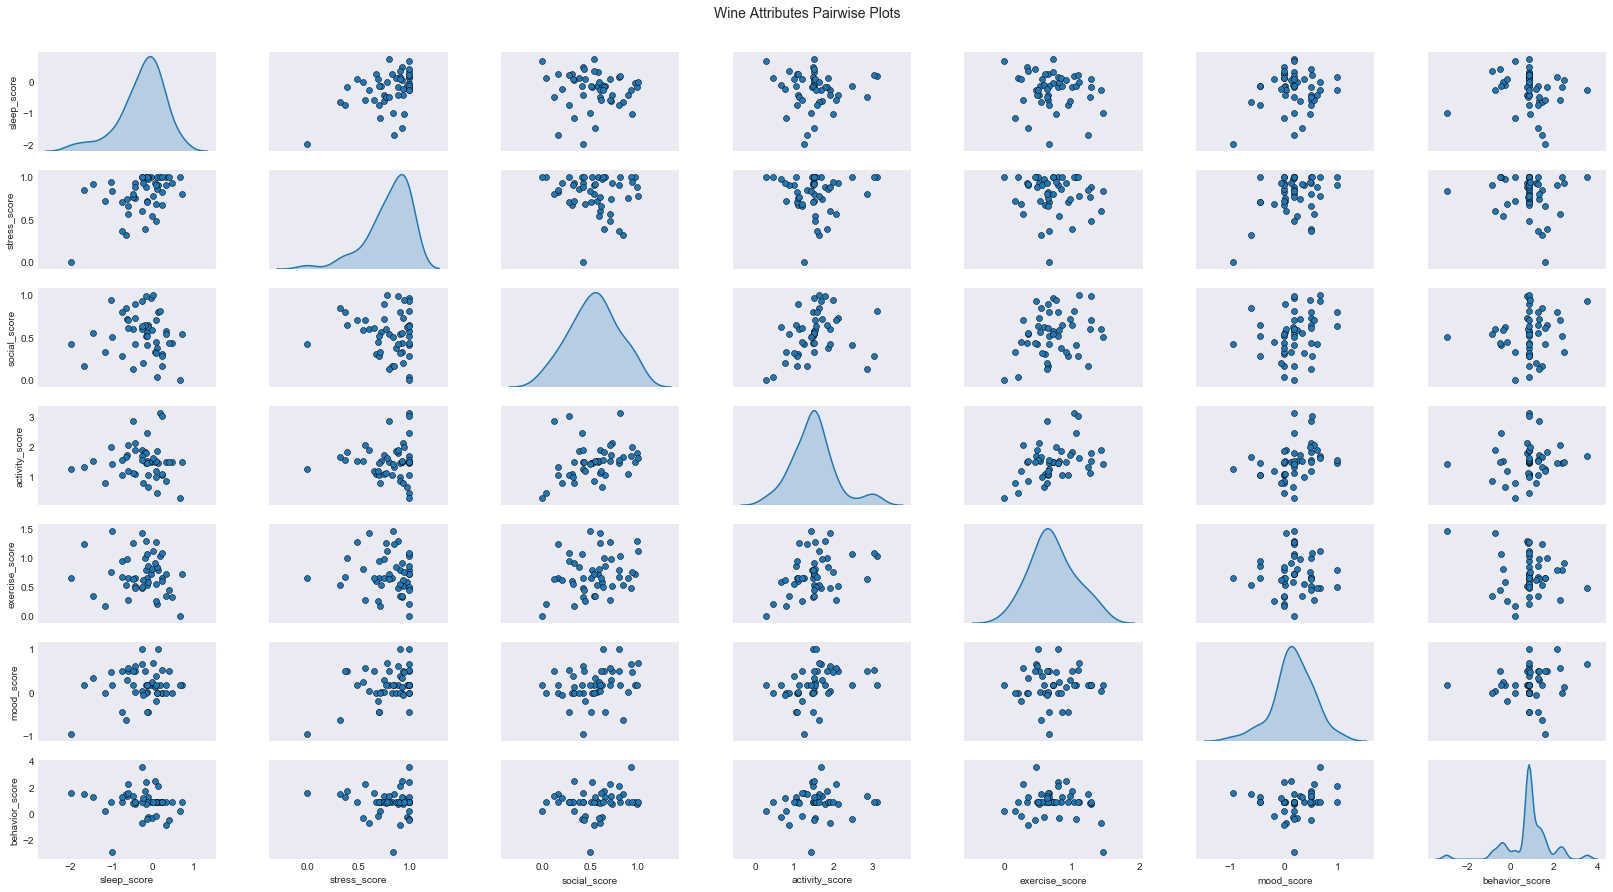

In [47]:
pp = sns.pairplot(ema_scores_df, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

In [48]:
ema_net_scores_df = pd.DataFrame(scale_df(ema_scores_df,scaler='Standard').sum(axis=1))\
                      .rename({0:'ema_net_score'},axis=1)
ema_net_scores_df.head()

,ema_net_score
uid,
u00,-1.067095
u01,2.260351
u02,2.156297
u03,-2.019879
u04,0.130447


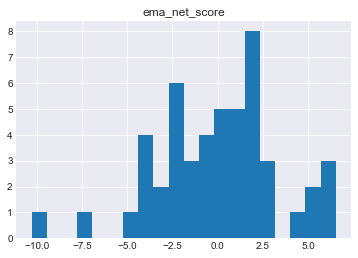

In [49]:
_ = ema_net_scores_df.hist(bins=20)

# C. Surveys
Use the data from this folder to assess mental health

In [50]:
surveys_path = './dataset/dataset/survey/'
[f for f in listdir(surveys_path)]

['BigFive.csv',
 'FlourishingScale.csv',
 'LonelinessScale.csv',
 'panas.csv',
 'PerceivedStressScale.csv',
 'PHQ-9.csv',
 'psqi.csv',
 'vr_12.csv']

## C.1. BigFive

In [51]:
#load data
big_five_df = pd.read_csv(surveys_path+'BigFive.csv').set_index(['uid','type'])

#new cols
big_five_df.columns = [col.split('.')[4].strip() for col in big_five_df.columns]

# convert strings to labels
label_encoder_dict = {'Disagree Strongly':1,
                      'Disagree a little':2,
                      'Neither agree nor disagree':3,
                      'Agree a little':4,
                      'Agree strongly':5}
big_five_df = big_five_df.replace(label_encoder_dict)

#new cols
bf_plus_minus_labels = [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
                        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]
big_five_df.columns = [f'bf_feat{i+1}_+' if label==1 else f'bf_feat{i+1}_-'
                         for i,label in enumerate(bf_plus_minus_labels)]

# find mean of pre- & post-survey scores 
big_five_df = big_five_df.groupby(level=0).mean()

In [52]:
big_five_df.head()

,bf_feat1_+,bf_feat2_-,bf_feat3_+,bf_feat4_-,bf_feat5_+,bf_feat6_-,bf_feat7_+,bf_feat8_-,bf_feat9_+,bf_feat10_+,bf_feat11_+,bf_feat12_-,bf_feat13_+,bf_feat14_-,bf_feat15_+,bf_feat16_+,bf_feat17_+,bf_feat18_-,bf_feat19_-,bf_feat20_+,bf_feat21_-,bf_feat22_+,bf_feat23_-,bf_feat24_+,bf_feat25_+,bf_feat26_-,bf_feat27_-,bf_feat28_+,bf_feat29_+,bf_feat30_+,bf_feat31_-,bf_feat32_+,bf_feat33_-,bf_feat34_+,bf_feat35_-,bf_feat36_+,bf_feat37_-,bf_feat38_+,bf_feat39_-,bf_feat40_+,bf_feat41_+,bf_feat42_+,bf_feat43_-,bf_feat44_+
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u00,4.0,3.0,3.0,3.0,5.0,4.0,3.5,4.0,3.5,5.0,4.0,3.5,4.5,4.5,4.5,4.5,4.0,4.0,3.5,4.5,3.0,5.0,2.5,4.0,5.0,5.0,3.5,4.5,4.0,4.5,4.0,3.0,2.0,2.5,1.5,4.5,4.5,3.0,1.5,4.5,2.0,4.0,4.0,4.0
u01,3.5,4.0,5.0,5.0,4.0,4.5,5.0,2.0,4.0,5.0,4.5,1.0,5.0,2.5,4.5,3.5,4.0,2.0,3.0,3.5,4.5,4.0,2.5,3.0,3.5,5.0,4.0,5.0,4.0,2.0,4.0,5.0,5.0,5.0,2.5,3.0,2.0,4.0,2.0,4.5,2.5,3.0,2.5,4.0
u02,1.5,4.0,4.5,1.5,3.5,5.0,4.0,2.0,2.5,4.0,2.0,4.0,5.0,4.0,2.5,2.0,2.5,1.5,4.0,2.5,5.0,3.5,2.5,3.0,3.5,4.5,4.0,4.0,3.5,4.5,4.0,3.5,5.0,2.5,5.0,2.0,2.5,4.0,4.0,4.0,3.5,4.0,4.0,3.0
u03,1.5,3.5,4.0,3.5,3.5,3.5,3.5,2.0,3.0,2.5,2.5,1.5,3.5,3.0,4.0,2.5,2.0,2.0,4.0,3.5,4.0,4.0,2.0,3.5,3.0,3.0,4.0,4.0,3.0,2.0,3.5,3.0,4.0,3.5,4.0,1.5,2.0,3.5,4.0,2.0,3.0,2.0,2.0,1.5
u04,3.0,3.5,3.5,2.5,2.5,4.0,4.5,4.0,1.0,3.5,4.5,2.5,3.0,4.5,2.0,3.5,1.5,4.0,5.0,3.5,4.0,2.5,3.0,1.0,3.0,2.0,3.0,3.0,4.0,4.0,4.5,4.0,2.5,1.5,5.0,2.0,4.0,3.5,4.5,3.5,2.5,4.0,4.5,3.5


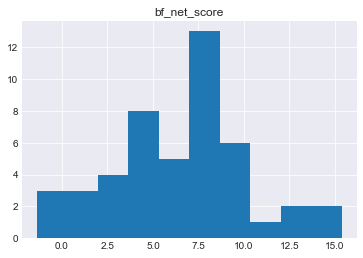

In [53]:
big_five_scores_df = compute_net_score(big_five_df,'bf_net_score')
_ = big_five_scores_df.hist()

## C.2. FlourishingScale

In [54]:
#load data
flourishing_df = pd.read_csv(surveys_path+'FlourishingScale.csv').set_index(['uid','type'])

# fill nulls
flourishing_df = fill_nulls(flourishing_df)

# new cols
flourishing_df.columns = [f'fl_feat{i}_+' for i in range(1,len(flourishing_df.columns)+1)]


# find mean of pre- & post-survey scores 
flourishing_df = flourishing_df.groupby(level=0).mean()

In [55]:
flourishing_df.head()

,fl_feat1_+,fl_feat2_+,fl_feat3_+,fl_feat4_+,fl_feat5_+,fl_feat6_+,fl_feat7_+,fl_feat8_+
uid,,,,,,,,
u00,6.5,5.5,6.0,6.0,6.0,6.5,6.0,4.5
u01,4.5,5.5,6.0,5.5,7.0,6.0,5.0,6.0
u02,5.5,6.5,4.5,6.0,5.0,6.0,4.5,7.0
u03,4.5,3.5,3.5,4.5,4.5,4.5,4.0,3.5
u04,4.0,5.0,4.0,3.0,3.0,3.0,3.0,5.0


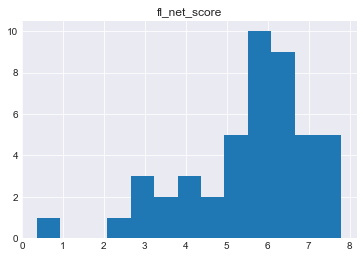

In [56]:
flourishing_scores_df = compute_net_score(flourishing_df,'fl_net_score')
_ = flourishing_scores_df.hist(bins=13)

## C.3. Loneliness Scale

In [57]:
#load data
loneliness_df = pd.read_csv(surveys_path+'LonelinessScale.csv').set_index(['uid','type'])

# fill nulls
loneliness_df = fill_nulls(loneliness_df)

#convert strings to labels
label_encoder_dict = {'Never':1, 'Rarely':2, 'Sometimes':3, 'Often':4}
loneliness_df = loneliness_df.replace(label_encoder_dict)

# new cols
ll_plus_minus_labels = [1,0,0,1,1,1,0,0,1,1,0,0,0,0,1,1,1,0,1,1]
loneliness_df.columns = [f'll_feat{i+1}_+' if label==1 else f'll_feat{i+1}_-'
                         for i,label in enumerate(ll_plus_minus_labels)]

# find mean of pre- & post-survey scores 
loneliness_df = loneliness_df.groupby(level=0).mean()

In [58]:
loneliness_df.head()

,ll_feat1_+,ll_feat2_-,ll_feat3_-,ll_feat4_+,ll_feat5_+,ll_feat6_+,ll_feat7_-,ll_feat8_-,ll_feat9_+,ll_feat10_+,ll_feat11_-,ll_feat12_-,ll_feat13_-,ll_feat14_-,ll_feat15_+,ll_feat16_+,ll_feat17_+,ll_feat18_-,ll_feat19_+,ll_feat20_+
uid,,,,,,,,,,,,,,,,,,,,
u00,3.0,2.0,1.5,2.5,3.5,3.0,1.0,1.5,3.5,3.5,2.0,2.5,1.0,1.0,3.5,2.5,3.5,3.0,4.0,4.0
u01,3.0,2.0,2.0,3.5,4.0,3.5,1.0,1.5,3.5,4.0,2.5,2.0,1.5,2.0,4.0,3.5,3.0,2.0,4.0,4.0
u02,3.5,2.0,2.0,4.0,4.0,4.0,1.0,2.5,2.0,4.0,2.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,4.0,4.0
u03,2.5,1.5,1.0,3.5,1.5,2.0,3.5,3.0,1.5,2.0,2.0,2.0,3.0,2.5,3.0,4.0,2.5,2.5,3.0,2.5
u04,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.5,2.0,3.5,3.5,2.5,3.0,2.5,2.0,2.5,2.5,3.0,2.5,2.5


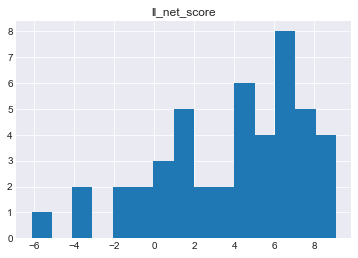

In [59]:
loneliness_scores_df = compute_net_score(loneliness_df,'ll_net_score')
_ = loneliness_scores_df.hist(bins=15)

## C.4. Perceived Stress Scale

In [60]:
# load data
perceived_stress_df = pd.read_csv(surveys_path+'PerceivedStressScale.csv')\
                            .set_index(['uid','type'])

# new cols
# perceived_stress_df.columns = ['upset','out_of_control','stressed',
#                                 'self_confidence','in_control','unable_to_cope',
#                                 'in_control_2', 'self_confidenc_2','out_of_control_2',
#                                 'overwhelmed']
ps_plus_minus_labels = [0,0,0,1,1,0,1,1,0,0]
perceived_stress_df.columns = [f'ps_feat{i+1}_+' if label==1 else f'ps_feat{i+1}_-'
                         for i,label in enumerate(ps_plus_minus_labels)]

# fill nulls
perceived_stress_df = fill_nulls(perceived_stress_df)

#convert strings to labels
label_encoder_dict = {'Never':1, 'Almost never':2 ,'Sometime':3, 'Fairly often':4,  'Very often':5 }
perceived_stress_df = perceived_stress_df.replace(label_encoder_dict)

# find mean of pre- & post-survey scores 
perceived_stress_df = perceived_stress_df.groupby(level=0).mean()

In [61]:
perceived_stress_df.head()

,ps_feat1_-,ps_feat2_-,ps_feat3_-,ps_feat4_+,ps_feat5_+,ps_feat6_-,ps_feat7_+,ps_feat8_+,ps_feat9_-,ps_feat10_-
uid,,,,,,,,,,
u00,2.5,3.0,3.5,4.0,3.0,4.0,3.5,3.0,3.0,3.0
u01,2.5,3.0,3.0,3.5,4.0,3.0,3.5,4.0,2.5,2.5
u02,3.5,3.0,4.0,4.0,2.5,4.0,2.5,3.0,3.5,3.0
u03,2.5,2.5,4.0,2.5,2.5,2.5,2.0,1.5,1.5,2.0
u04,2.5,2.0,4.5,3.5,3.0,3.0,3.5,2.5,2.5,3.0


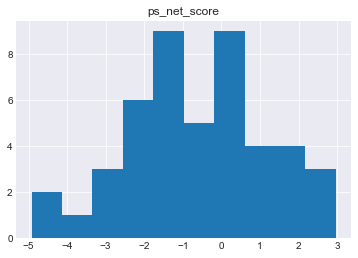

In [62]:
perceived_stress_scores_df = compute_net_score(perceived_stress_df,'ps_net_score')
_ = perceived_stress_scores_df.hist()

## Join all Survey dfs

In [63]:
## Join all Survey df's

survey_scores_df_list = [big_five_scores_df, flourishing_scores_df, loneliness_scores_df, perceived_stress_scores_df]

# Join all dfs on index = uid
survey_scores_df = big_five_scores_df
for df in survey_scores_df_list[1:]:
    survey_scores_df = pd.merge(survey_scores_df,df,how='outer',on=['uid'])

# fill null cols with most_freq value of col
survey_scores_df = fill_nulls(survey_scores_df)

In [64]:
survey_scores_df.head()

,bf_net_score,fl_net_score,ll_net_score,ps_net_score
uid,,,,
u00,8.357143,6.300000,5.816667,-0.933333
u01,9.220238,6.083333,6.850000,0.276190
u02,0.821429,5.900000,7.516667,-2.044048
u03,1.446429,3.583333,0.866667,-1.317857
u04,-0.958333,3.100000,-0.483333,-0.891667


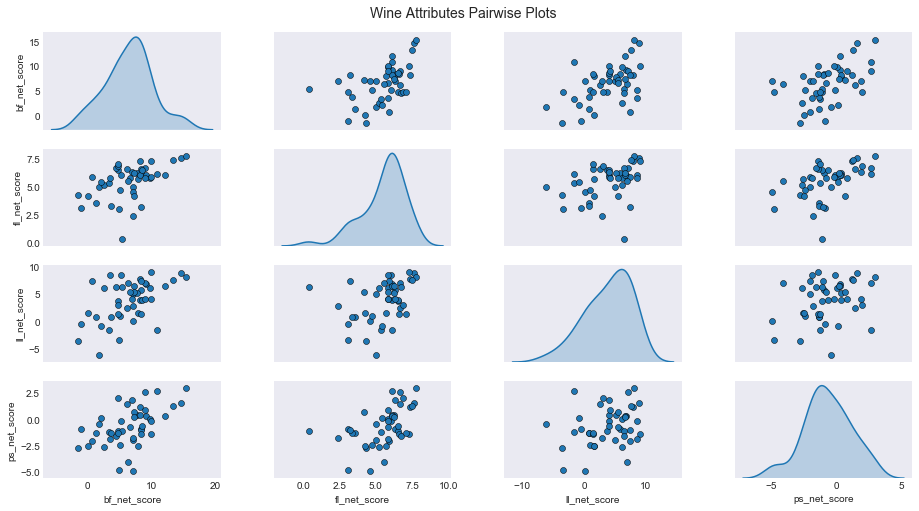

In [65]:
pp = sns.pairplot(survey_scores_df, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

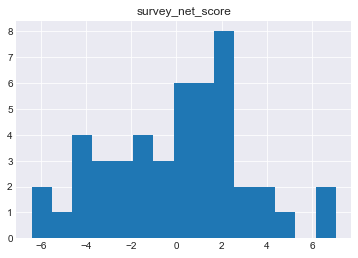

In [66]:
survey_net_scores_df = pd.DataFrame(scale_df(survey_scores_df,scaler='Standard').sum(axis=1))\
                      .rename({0:'survey_net_score'},axis=1)
_ = survey_net_scores_df.hist(bins=15)

# D. Education
Use the data from this folder to assess school performance

In [67]:
edu_path = './dataset/dataset/education/'
[f for f in listdir(edu_path)]

['class.csv', 'class_info.json', 'deadlines.csv', 'grades.csv', 'piazza.csv']

In [68]:
edu_df = pd.read_csv(edu_path+'grades.csv').set_index(['uid']).iloc[:,[0]]
edu_df.columns = ['GPA']

In [69]:
edu_df.head()

,GPA
uid,
u01,2.863
u02,3.505
u04,3.029
u05,3.679
u07,3.474


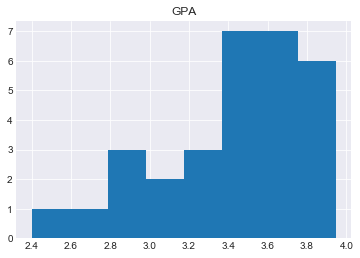

In [74]:
_ = edu_df.hist(bins=8)

# Net Dataset

In [70]:
all_df = edu_df
for df in [phone_scores_df, ema_scores_df , survey_scores_df]:
    all_df = pd.merge(all_df, df, how='outer', on=['uid'])

In [71]:
all_df.head()

,GPA,tot_conv_sec,tot_phonelock_sec,pct_phone_usage,sleep_score,stress_score,social_score,activity_score,exercise_score,mood_score,behavior_score,bf_net_score,fl_net_score,ll_net_score,ps_net_score
uid,,,,,,,,,,,,,,,
u01,2.863,1664813,3084557,0.539725,-0.425579,0.935811,0.725806,2.120370,0.519481,0.500000,0.763769,9.220238,6.083333,6.850000,0.276190
u02,3.505,1260149,1613057,0.781218,-0.170330,1.000000,0.522581,1.445933,0.792929,0.000000,2.396797,0.821429,5.900000,7.516667,-2.044048
u04,3.029,1505986,3493669,0.431061,-0.261197,0.607313,0.602151,1.908425,1.432239,0.034091,-0.720497,-0.958333,3.100000,-0.483333,-0.891667
u05,3.679,1086616,2404358,0.451936,-0.056762,1.000000,0.967742,1.508859,0.726607,0.183974,0.860762,9.053571,6.683333,7.166667,2.648810
u07,3.474,808665,2367839,0.341520,-0.126340,1.000000,0.653226,1.042549,0.860140,-0.454545,1.284720,4.779762,6.533333,3.800000,-1.126190


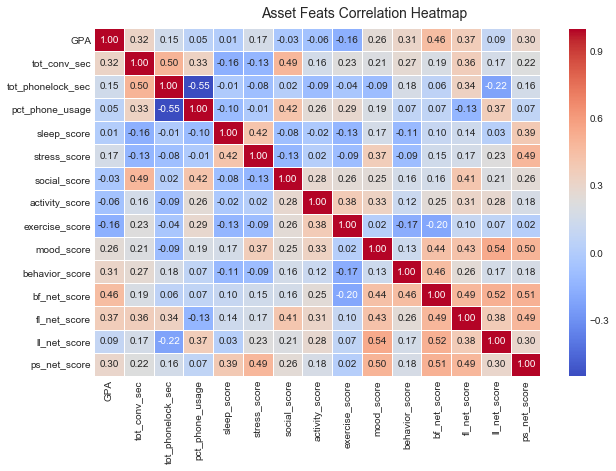

In [72]:
# Correlation Matrix Heatmap
fig, ax = plt.subplots(figsize=(10, 6))
corr = all_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
fig.subplots_adjust(top=0.93)
t= fig.suptitle('Asset Feats Correlation Heatmap', fontsize=14)

# Comments:

1. We didn't find any strong linear correlations between the engineered features and GPA.
2. We didn't find any strong linear correlations among the engineered features themselves.
3. Some of the features appear to be gaussian, though it's hard to support this observation due to the limited number of samples.

# Conclusions:

The dataset is very rich in data and a lot of interesting and diverse features can be extracted from it. However, the limited number of samples obscures the relationship among the features and one needs to collect more samples in order to arrive to any statistically significant conclusions.
